<a href="https://colab.research.google.com/github/LoPA607/IE643_project/blob/main/final_model_metrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision pillow tqdm lpips scikit-image matplotlib git+https://github.com/openai/CLIP.git


Device: cuda
Upload content (clean) image:


Saving clean.jpg to clean.jpg
Upload extreme/style image (optional):


Saving hidemotionblur.png to hidemotionblur.png


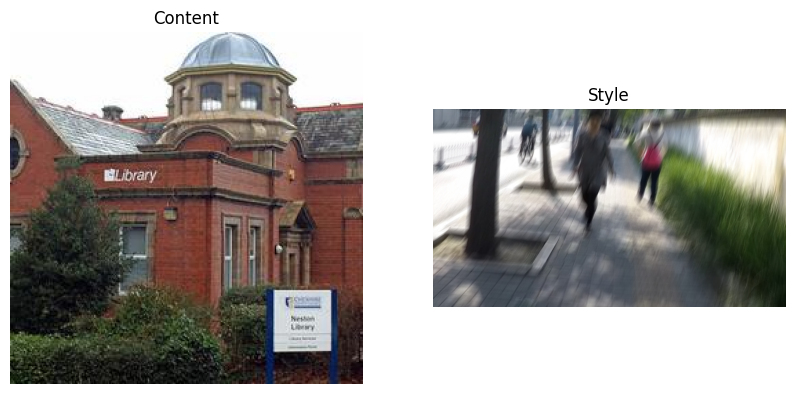

Running style-transfer with multi-layer attention alignment...
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 83.0MB/s]


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 176MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth


100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 37.5MiB/s]
iter 699 L=873.6715 LPIPS=0.8532 SSIM=0.2583 CLIPsim=0.5991: 100%|██████████| 700/700 [01:06<00:00, 10.57it/s]


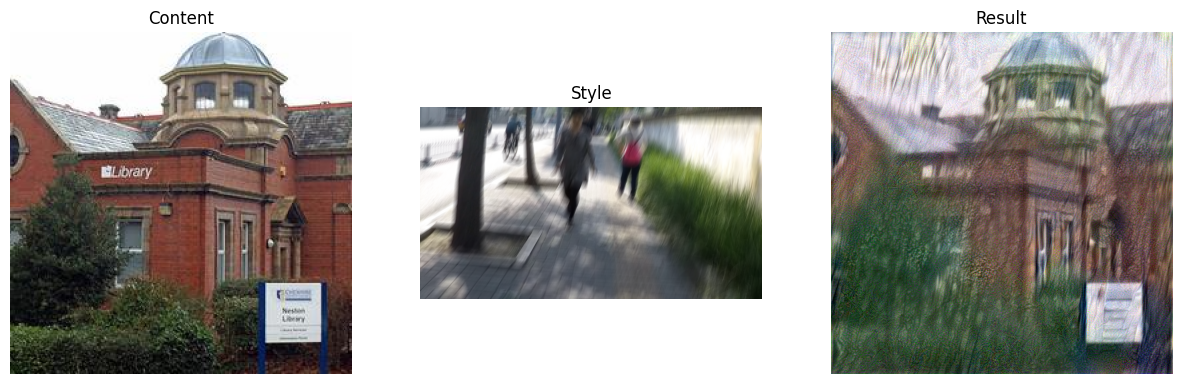

Saved result as style_multilayer_attention_result.png


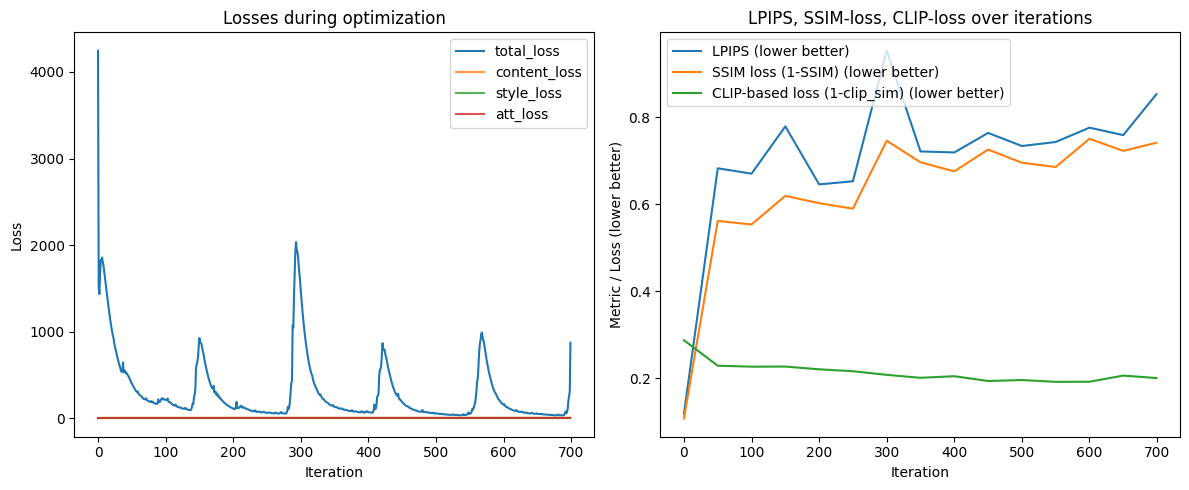

Saved metric plot as style_transfer_metrics.png


<Figure size 640x480 with 0 Axes>

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import lpips
from skimage.metrics import structural_similarity as ssim
import io, os
import torch.nn.functional as F
import clip  # from OpenAI's CLIP repo

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------- Utilities ----------
def load_image(path_or_bytes, target_size=None):
    if isinstance(path_or_bytes, bytes):
        img = Image.open(io.BytesIO(path_or_bytes)).convert('RGB')
    else:
        img = Image.open(path_or_bytes).convert('RGB')
    if target_size is not None:
        img = img.resize(target_size, Image.LANCZOS)
    return img

def pil_to_tensor(img):
    return transforms.ToTensor()(img).unsqueeze(0).to(device)

def tensor_to_pil(tensor):
    t = tensor.detach().cpu().clamp(0,1).squeeze(0)
    return transforms.ToPILImage()(t)

def show_images(imgs, titles=None, figsize=(12,6)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i,img in enumerate(imgs):
        plt.subplot(1,n,i+1)
        if isinstance(img, torch.Tensor):
            plt.imshow(tensor_to_pil(img))
        else:
            plt.imshow(img)
        plt.axis('off')
        if titles:
            plt.title(titles[i])
    plt.show()

# ---------- Create an "extreme" shifted image ----------
def make_extreme_shifted(img_pil, translate=(40,30), rotate=30, blur_radius=8, noise_std=0.2):
    w,h = img_pil.size
    tx, ty = translate
    canvas = Image.new('RGB',(w+abs(tx)+10,h+abs(ty)+10),(0,0,0))
    paste_x, paste_y = max(tx,0), max(ty,0)
    canvas.paste(img_pil,(paste_x,paste_y))
    cropped = canvas.crop((0,0,w,h))
    rotated = cropped.rotate(rotate,resample=Image.BILINEAR,expand=False,fillcolor=(0,0,0))
    blurred = rotated.filter(ImageFilter.GaussianBlur(radius=blur_radius))
    arr = np.array(blurred).astype(np.float32)/255.0
    noise = np.random.normal(0,noise_std,arr.shape).astype(np.float32)
    arr = np.clip(arr+noise,0,1)
    return Image.fromarray((arr*255).astype(np.uint8))

# ---------- VGG feature extractor ----------
class VGGFeatures(nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
        self.layer_name_map = {
            '0': "conv1_1",
            '5': "conv2_1",
            '10': "conv3_1",
            '19': "conv4_1",
            '21': "conv4_2",  # content
            '28': "conv5_1"
        }
        self.vgg = vgg_pretrained
        if not requires_grad:
            for p in self.vgg.parameters():
                p.requires_grad = False

    def forward(self, x):
        features = {}
        for idx, layer in enumerate(self.vgg):
            x = layer(x)
            name = self.layer_name_map.get(str(idx))
            if name:
                features[name] = x
            if str(idx) == '28':
                break
        return features

# ---------- Loss helpers ----------
def gram_matrix(x):
    b, c, h, w = x.size()
    feat = x.view(b, c, h*w)
    G = torch.matmul(feat, feat.transpose(1,2))
    return G / (c * h * w)

def attention_map_from_feature(fmap, eps=1e-8):
    att = torch.norm(fmap, p=2, dim=1, keepdim=True)
    b, _, h, w = att.shape
    att_flat = att.view(b, -1)
    att_norm = torch.softmax(att_flat, dim=1).view(b,1,h,w)
    return att_norm

# ---------- Style transfer pipeline ----------
def style_transfer_with_attention(content_img_path, style_img_path,
                                   size=(512,512),
                                   iters=1500,
                                   content_weight=1e0,
                                   style_weight=1e3,
                                   att_weight=1e2,
                                   lr=0.02,
                                   use_init='content',
                                   log_every=50):

    content_t = pil_to_tensor(load_image(content_img_path, target_size=size))
    style_t   = pil_to_tensor(load_image(style_img_path, target_size=size))

    mean = torch.tensor([0.485,0.456,0.406]).to(device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).to(device).view(1,3,1,1)
    normalize = lambda x: (x-mean)/std

    vgg = VGGFeatures().to(device)
    style_feats = vgg(normalize(style_t))
    content_feats = vgg(normalize(content_t))

    if use_init=='content':
        gen = content_t.clone().requires_grad_(True)
    else:
        gen = (torch.randn_like(content_t)*0.1 + content_t*0.5).requires_grad_(True)

    optimizer = optim.Adam([gen], lr=lr)
    loss_fn_lpips = lpips.LPIPS(net='alex').to(device)

    # CLIP model & preprocess
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    clip_model.eval()

    # histories
    loss_history = []        # total loss
    content_loss_hist = []
    style_loss_hist = []
    att_loss_hist = []
    lpips_hist = []
    ssim_hist = []
    clip_sim_hist = []
    iter_hist = []

    pbar = tqdm(range(iters))
    for i in pbar:
        optimizer.zero_grad()
        gen_norm = normalize(gen)
        feats = vgg(gen_norm)

        # Content loss
        content_loss = torch.nn.functional.mse_loss(feats['conv4_2'], content_feats['conv4_2'])

        # Style loss
        style_layers = ['conv1_1','conv2_1','conv3_1','conv4_1','conv5_1']
        style_loss = 0.0
        for l in style_layers:
            Gg = gram_matrix(feats[l])
            Gs = gram_matrix(style_feats[l])
            style_loss += torch.nn.functional.mse_loss(Gg, Gs)

        # Multi-layer attention loss
        att_layers = ['conv3_1','conv4_1','conv5_1']
        att_loss = 0.0
        for l in att_layers:
            att_gen = attention_map_from_feature(feats[l])
            att_style = attention_map_from_feature(style_feats[l])
            att_loss += torch.nn.functional.mse_loss(att_gen, att_style)

        # Total loss
        total_loss = content_weight*content_loss + style_weight*style_loss + att_weight*att_loss
        total_loss.backward()
        optimizer.step()
        with torch.no_grad(): gen.clamp_(0,1)

        # store basic losses
        loss_history.append(total_loss.item())
        content_loss_hist.append(content_loss.item())
        style_loss_hist.append(style_loss.item())
        att_loss_hist.append(att_loss.item())

        # compute LPIPS, SSIM and CLIP similarity at intervals
        if (i % log_every == 0) or (i == iters-1):
            with torch.no_grad():
                # LPIPS: content vs gen (LPIPS expects [-1,1])
                lp_val = loss_fn_lpips(content_t*2-1, gen*2-1).item()
                lpips_hist.append(lp_val)

                # SSIM: content vs gen (skimage expects H,W,C float in 0..1)
                gen_pil = tensor_to_pil(gen)
                content_pil = tensor_to_pil(content_t)
                g_np = np.array(gen_pil).astype(np.float32)/255.0
                c_np = np.array(content_pil).astype(np.float32)/255.0
                win_size = 7
                if min(g_np.shape[:2])>=win_size:
                    ssim_val = ssim(c_np,g_np,win_size=win_size,channel_axis=2,data_range=1.0)
                else:
                    # fallback: compute simple structural similarity on grayscale
                    import cv2
                    g_gray = cv2.cvtColor((g_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
                    c_gray = cv2.cvtColor((c_np*255).astype(np.uint8), cv2.COLOR_RGB2GRAY).astype(np.float32)/255.0
                    ssim_val = ssim(c_gray, g_gray, data_range=1.0)
                # convert to "loss" if desired: ssim_loss = 1 - ssim_val
                ssim_hist.append(ssim_val)

                # CLIP similarity (style vs gen) -> cosine similarity of normalized embeddings
                # preprocess returns tensor in range 0..1 with normalization suitable for CLIP
                gen_clip_t = clip_preprocess(gen_pil).unsqueeze(0).to(device)
                style_clip_t = clip_preprocess(tensor_to_pil(style_t)).unsqueeze(0).to(device)
                # encode
                emb_gen = clip_model.encode_image(gen_clip_t)
                emb_style = clip_model.encode_image(style_clip_t)
                # normalize
                emb_gen = emb_gen / emb_gen.norm(dim=-1, keepdim=True)
                emb_style = emb_style / emb_style.norm(dim=-1, keepdim=True)
                clip_sim = F.cosine_similarity(emb_gen, emb_style).item()  # in [-1,1]
                clip_sim_hist.append(clip_sim)  # similarity (higher = more similar)

                iter_hist.append(i)

            pbar.set_description(f"iter {i} L={total_loss.item():.4f} LPIPS={lp_val:.4f} SSIM={ssim_val:.4f} CLIPsim={clip_sim:.4f}")

    # Package results
    metrics = {
        'loss_history': loss_history,
        'content_loss_hist': content_loss_hist,
        'style_loss_hist': style_loss_hist,
        'att_loss_hist': att_loss_hist,
        'iter_hist': iter_hist,
        'lpips_hist': lpips_hist,
        'ssim_hist': ssim_hist,
        'clip_sim_hist': clip_sim_hist
    }

    return gen.detach(), metrics

# ---------- Upload images (Colab UI) ----------
from google.colab import files
print("Upload content (clean) image:")
uploaded = files.upload()
content_path = list(uploaded.keys())[0]

print("Upload extreme/style image (optional):")
uploaded2 = files.upload()
if len(uploaded2)>0:
    style_path = list(uploaded2.keys())[0]
else:
    base = load_image(content_path)
    style_img = make_extreme_shifted(base, translate=(120,80), rotate=35, blur_radius=10, noise_std=0.35)
    style_path = "synth_style.png"
    style_img.save(style_path)
    print(f"Synthesized extreme style saved to {style_path}")

content_img = load_image(content_path)
style_img   = load_image(style_path)
show_images([content_img, style_img], titles=['Content','Style'], figsize=(10,5))

# ---------- Run style transfer ----------
print("Running style-transfer with multi-layer attention alignment...")
out_t, metrics = style_transfer_with_attention(content_path, style_path,
                                      size=(512,512),
                                      iters=700,
                                      content_weight=1e-3,
                                      style_weight=1e7,
                                      att_weight=1e3,
                                      lr=0.02,
                                      log_every=50)

out_pil = tensor_to_pil(out_t)
show_images([content_img, style_img, out_pil], titles=['Content','Style','Result'], figsize=(15,6))
out_pil.save("style_multilayer_attention_result.png")
print("Saved result as style_multilayer_attention_result.png")

# ---------- Plotting ----------
iter_hist = metrics['iter_hist']
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(metrics['loss_history'], label='total_loss')
plt.plot(metrics['content_loss_hist'], label='content_loss', alpha=0.8)
plt.plot(metrics['style_loss_hist'], label='style_loss', alpha=0.8)
plt.plot(metrics['att_loss_hist'], label='att_loss', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses during optimization')

# Right: LPIPS, SSIM, CLIP-sim (sampled every log_every)
plt.subplot(1,2,2)
# Make sure lengths align (iter_hist x-values)
x = iter_hist
lp = metrics['lpips_hist']
ss = metrics['ssim_hist']      # already similarity 0..1
cs = metrics['clip_sim_hist']  # similarity -1..1 (usually positive)
# Normalize clip sim into 0..1 for nicer display: (cs+1)/2
cs_norm = [(c+1.0)/2.0 for c in cs]
plt.plot(x, lp, label='LPIPS (lower better)')
plt.plot(x, [1.0 - s for s in ss], label='SSIM loss (1-SSIM) (lower better)')  # plot as loss
plt.plot(x, [1.0 - c for c in cs_norm], label='CLIP-based loss (1-clip_sim) (lower better)')
plt.xlabel('Iteration')
plt.ylabel('Metric / Loss (lower better)')
plt.legend()
plt.title('LPIPS, SSIM-loss, CLIP-loss over iterations')
plt.tight_layout()
plt.show()

# Save plots
plt.savefig("style_transfer_metrics.png")
print("Saved metric plot as style_transfer_metrics.png")